In [5]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
from matplotlib.lines import Line2D
sys.path.append('../') 

In [12]:
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ] 
cpath = '/Users/linlin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/cap/dataexp/pySuStaIn/dat/'
lftp = pd.read_csv(cpath+'lftp.csv')
df = pd.read_csv(cpath+'wide_data.csv')

In [13]:
def roi_cluster_violin(data, x, y,roi_name,hue_cat,title_text,labels,strip=True,colors = sns.set_palette('tab20'),**kwargs): 
    #each x gets its own violin. hue splits the violin. each roi get its own plot. 
    #inner: “box”, “quart”, “point”, “stick”,
    # Define the pairs  
    pairs = [
        ('L_MTL', 'R_MTL'),
        ('L_temporal', 'R_temporal'),
        ('L_frontal', 'R_frontal'),
        ('L_occipital', 'R_occipital'),
        ('L_parietal', 'R_parietal')
    ]
    fig, axes = plt.subplots(1,5,figsize=(26,6), sharey = True)#, dpi=480)

    for i, (lobe_l, lobe_r) in enumerate(pairs):
        #row = i // 5
        col = i % 5
        sns.violinplot(data=data[data[roi_name].isin([lobe_l, lobe_r])], x=x, y=y, hue=hue_cat, 
                    split=True,
                    fill=False,
                    ax=axes[col],palette=colors,**kwargs)
        if strip:
            sns.stripplot(data=data[data[roi_name].isin([lobe_l, lobe_r])], 
                      x=x, y=y, hue=hue_cat, 
                    dodge=True,jitter=True, alpha=0.5, size = 4, legend = False,ax=axes[col],palette=colors)#marker='o'

        axes[col].set_title(lobe_l[2:],fontsize=16)
        axes[col].set_xlabel(None)
        axes[col].set_ylabel(None)#lobe_l[2:],fontsize=16)
        axes[col].tick_params(axis='y', labelsize=16)    
        axes[col].tick_params(axis='x', labelsize=16)   

        # Set legend to None for all subplots except the last one
        if i != len(pairs):
            handles, _ = axes[ col].get_legend_handles_labels()
            axes[col].legend().set_visible(False)  

    # Create a single legend in the last subplot
    axes[0].legend(handles, labels, loc='upper left')
    plt.yticks(size=15)
    plt.suptitle(title_text,fontsize=16)
    plt.tight_layout()
    plt.show()


# Standardization

## cn z-score

In [14]:
df[df.subj == 'LDS0670468']

,subj,dx,L_MTL,L_frontal,L_occipital,L_parietal,L_temporal,R_MTL,R_frontal,R_occipital,R_parietal,R_temporal


In [15]:
# https://stackoverflow.com/questions/24984178/different-std-in-pandas-vs-numpy diff
 

cn_idx = df.index[df['dx'] == 'CN']
dat = df.loc[:,lobes].values
data_control = dat[cn_idx] 
std_control = np.std(data_control,axis=0) 

In [16]:
std_control

array([0.08114455, 0.08372625, 0.05554475, 0.05612856, 0.05521304,
       0.05775019, 0.04994682, 0.05110131, 0.05972359, 0.05951497])

In [17]:
# convert to np array and get control mean, sd 
eoad_idx = df.index[df['dx'] == 'EOAD']
dat = df.loc[:,lobes].values
data_control = dat[cn_idx] 
mean_control = np.mean(data_control,axis=0) # this is mean across rows. 10 mean for 10 ROIs
std_control = np.std(data_control,axis=0) 
cndat = {
    'lobe': lobes,
    'mean_cn':mean_control ,
    'sd_cn': std_control,
}
pd.DataFrame(cndat)



,lobe,mean_cn,sd_cn
0,L_MTL,1.138153,0.081145
1,R_MTL,1.139229,0.083726
2,L_temporal,1.127988,0.055545
3,R_temporal,1.126217,0.056129
4,L_frontal,1.052254,0.055213
5,R_frontal,1.056771,0.057750
6,L_occipital,1.105393,0.049947
7,R_occipital,1.099908,0.051101
8,L_parietal,1.076035,0.059724
9,R_parietal,1.074975,0.059515


### cn and eoad mean/sd

In [21]:
# z-score the data
zdata = (dat-mean_control)/std_control
zdata_ctrl = zdata[cn_idx]
zdata_eoad = zdata[eoad_idx]

In [22]:
# check standardization

# Check that the mean of the control population is 0 (close enough!)
print('Mean of controls is ',np.mean(zdata_ctrl,axis=0))
# Check that the standard deviation of the control population is 1
print('Standard deviation of controls is ',np.std(zdata_ctrl,axis=0))
# Check that the mean of the whole dataset is positive
print('Mean of whole dataset is ',np.mean(zdata,axis=0))
# Check that the standard deviation of the whole dataset is greater than 1
print('Standard deviation of whole dataset is ',np.std(zdata,axis=0))

Mean of controls is  [ 3.16918209e-15  5.46280193e-15 -5.07722021e-16  5.29753009e-15
  1.91955038e-15 -1.26035546e-15 -1.02973186e-14 -1.05244096e-14
 -5.52840602e-15  5.28869877e-15]
Standard deviation of controls is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean of whole dataset is  [ 4.17834088  3.77937346 12.02589089 11.07999165  8.03740139  6.99333153
 10.43549504  9.77161554 12.30638161 11.82803882]
Standard deviation of whole dataset is  [ 3.99142142  3.72368834 11.55380261 10.72659088  8.98704607  8.17564998
 12.20481157 11.76448633 12.21278039 11.97178482]


In [29]:
zdf = pd.DataFrame(zdata,columns=lobes)
zdf['dx'] = df.dx
zdf['subj'] = df.subj
zdf = zdf[zdf.dx.isin(['EOAD','CN'])]
zdf.to_csv(cpath+'zdata.csv',index=False)

In [30]:
zdf.dx.unique()

array(['CN', 'EOAD'], dtype=object)

In [31]:
zdf.head(2)

,L_MTL,R_MTL,L_temporal,R_temporal,L_frontal,R_frontal,L_occipital,R_occipital,L_parietal,R_parietal,dx,subj
0,0.901321,0.876611,0.094889,0.423627,-0.171637,-0.372836,0.061299,0.270728,0.036850,0.170100,CN,LDS0070120
1,9.105077,6.894892,33.802614,29.222036,26.596894,20.722339,39.857132,34.186927,34.868241,32.569683,EOAD,LDS0070166


### KDE visualization

In [32]:
def pdf_roi(df, description, xlab, eoad_idx = eoad_idx, cn_idx = cn_idx,  
            rois = lobes, col = sns.color_palette('tab20')):
 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    # Plot KDEs for cn and eoad
    for idx, lobe in enumerate(rois):
        sns.kdeplot(df.loc[eoad_idx, lobe], label='EOAD', linestyle='solid', color=col[idx], ax=axes[1])
        sns.kdeplot(df.loc[cn_idx, lobe], label='CN', linestyle='dashed', color=col[idx], ax=axes[1])
        axes[1].set_title('CN/EOAD separate')
        axes[1].set_xlabel(xlab)
        handles, labels = axes[1].get_legend_handles_labels() 
    # Plot KDEs for all data
    for idx, lobe in enumerate(rois):
        sns.kdeplot(df.loc[:, lobe], label=f'{lobe}', linestyle='solid', color=col[idx], ax=axes[0])
        axes[0].set_title('all data')
        axes[0].set_xlabel(xlab)    
    # Add legends
    axes[0].legend(loc='upper right', title='ROI')
    axes[1].legend(handles[0:2],labels[0:2],loc='upper right', title='dx')
    # Set common title
    plt.suptitle(f'KDE plots of {description} in each ROI')
    plt.tight_layout()
    plt.show()
    return fig, axes


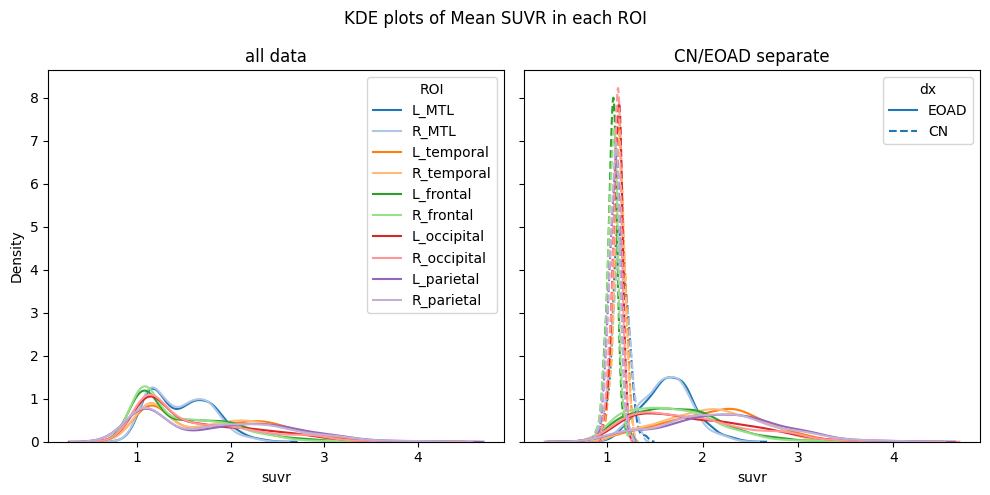

In [33]:
fig, axes = pdf_roi(df ,'Mean SUVR', 'suvr')

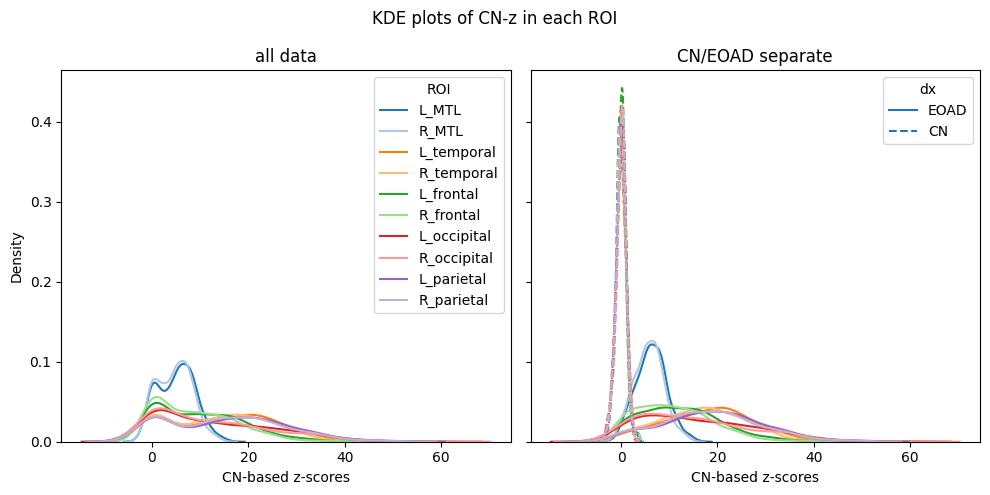

In [36]:
fig, axes = pdf_roi(zdf ,'CN-z', 'CN-based z-scores')